In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


In [ ]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2, padding=0),
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/25], Loss: 0.0753
Epoch [2/25], Loss: 0.0351
Epoch [3/25], Loss: 0.0290
Epoch [4/25], Loss: 0.0256
Epoch [5/25], Loss: 0.0227
Epoch [6/25], Loss: 0.0210
Epoch [7/25], Loss: 0.0200
Epoch [8/25], Loss: 0.0192
Epoch [9/25], Loss: 0.0185
Epoch [10/25], Loss: 0.0179
Epoch [11/25], Loss: 0.0173
Epoch [12/25], Loss: 0.0169
Epoch [13/25], Loss: 0.0163
Epoch [14/25], Loss: 0.0160
Epoch [15/25], Loss: 0.0156
Epoch [16/25], Loss: 0.0153
Epoch [17/25], Loss: 0.0151
Epoch [18/25], Loss: 0.0149
Epoch [19/25], Loss: 0.0146
Epoch [20/25], Loss: 0.0144
Epoch [21/25], Loss: 0.0143
Epoch [22/25], Loss: 0.0142
Epoch [23/25], Loss: 0.0140
Epoch [24/25], Loss: 0.0140
Epoch [25/25], Loss: 0.0138


In [ ]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, encoder):
        super(Classifier, self).__init__()
        self.encoder = encoder

        # Adding classifier layers
        self.fc1 = nn.Linear(8 * 8 * 8, 512)  # Adjust this size based on the encoder output
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 classes for CIFAR-10

        # Using nn.ReLU directly instead of F.relu
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass through encoder
        x = self.encoder(x)

        # Flatten the encoder output
        x = x.view(x.size(0), -1)  # Flatten the output (batch_size, flattened_size)

        # Pass through classifier
        x = self.fc1(x)
        x = self.relu(x)  # Apply ReLU activation after fc1
        x = self.fc2(x)
        x = self.relu(x)  # Apply ReLU activation after fc2
        x = self.fc3(x)

        return x


# Initialize the Autoencoder model and the classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Autoencoder().encoder  # Use only the encoder part
model = Classifier(encoder).to(device)

# Loss and optimizer for classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass through the encoder + classifier
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Evaluate the classifier on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/10], Loss: 1.6176, Accuracy: 40.33%
Epoch [2/10], Loss: 1.2446, Accuracy: 54.63%
Epoch [3/10], Loss: 1.0573, Accuracy: 61.98%
Epoch [4/10], Loss: 0.9429, Accuracy: 66.56%
Epoch [5/10], Loss: 0.8508, Accuracy: 69.79%
Epoch [6/10], Loss: 0.7836, Accuracy: 72.09%
Epoch [7/10], Loss: 0.7157, Accuracy: 74.75%
Epoch [8/10], Loss: 0.6593, Accuracy: 76.77%
Epoch [9/10], Loss: 0.6028, Accuracy: 78.78%
Epoch [10/10], Loss: 0.5444, Accuracy: 80.68%
Test Accuracy: 70.98%


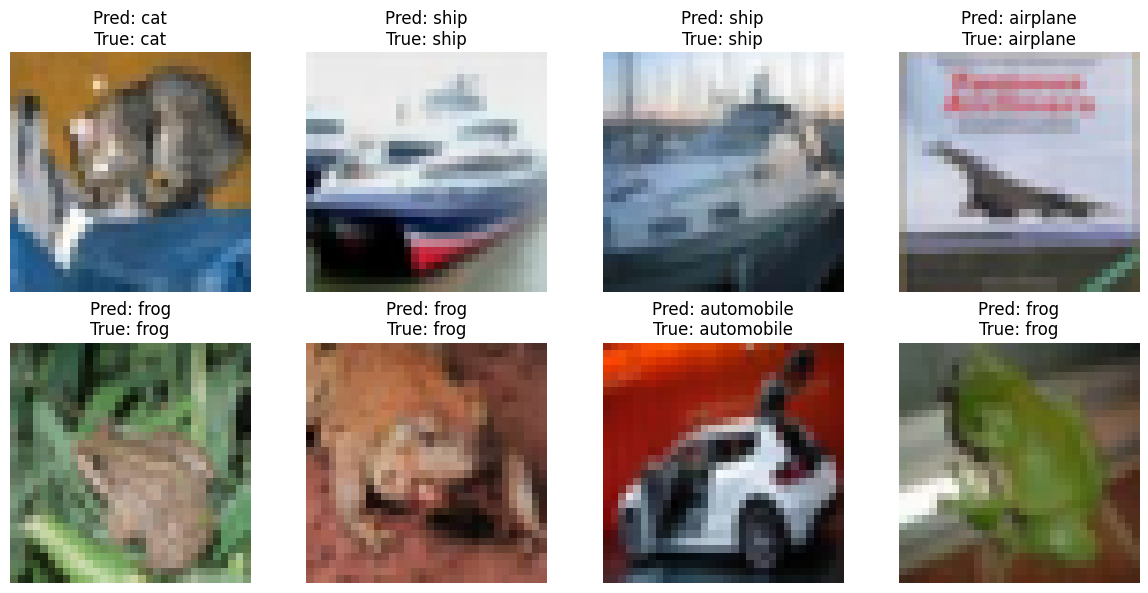

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = train_dataset.classes

def imshow(img):
    img = img * 0.5 + 0.5  # Undo normalization (from [-1, 1] to [0, 1])
    img = img.clamp(0, 1)  # Ensure valid range
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imshow(images[i])
    plt.title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
plt.tight_layout()
plt.show()